In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import asyncio
import uuid
import os

from langchain_core.messages import HumanMessage
from langfuse.langchain import CallbackHandler

from IPython.display import display, Markdown, clear_output

from src.ai.assistant import build_graph

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
async def visualize_assistant_graph():
    graph = await build_graph()
    return graph

In [6]:
assistant_graph = await visualize_assistant_graph()
print(assistant_graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	conversation(conversation)
	vector_db_node(vector_db_node)
	synthesizer(synthesizer)
	__end__([<p>__end__</p>]):::last
	__start__ --> conversation;
	conversation --> vector_db_node;
	vector_db_node --> synthesizer;
	synthesizer --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



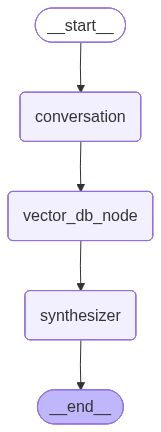

In [7]:
assistant_graph

In [8]:
from typing import AsyncIterator, AsyncGenerator

async def ai_response_generator(stream: AsyncIterator) -> AsyncGenerator[str, None]:
    async for message_chunk, metadata in stream:
        if metadata['langgraph_node'] == 'synthesizer':
            yield message_chunk.content

In [9]:
def preprocess_for_markdown(text: str) -> str:
    """
    Convert LaTeX delimiters \(...\), \[...\] to $...$ and $$...$$
    so Jupyter Markdown + MathJax render them correctly.
    """
    return (
        text
        .replace(r"\(", "$")
        .replace(r"\)", "$")
        .replace(r"\[", "$$")
        .replace(r"\]", "$$")
    )

In [10]:
async def chat():
    # Full conversation as Markdown
    transcript = ""

    langfuse_handler = CallbackHandler()
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}, "callbacks": [langfuse_handler]}

    while True:
        user_message = input("\nUser: ")

        if user_message.strip() == "/bye":
            print("Exiting chat. Goodbye!")
            break

        # Add user message to transcript
        transcript += f"**User:** {user_message}\n\n**AI:** "

        # Start streaming from your LangGraph assistant
        graph_steps_stream = assistant_graph.astream(
            {"messages": [HumanMessage(content=user_message)]},
            config=config,
            stream_mode="messages",
        )

        response_gen = ai_response_generator(graph_steps_stream)

        # Stream AI chunks, update transcript, and re-render
        async for chunk in response_gen:
            transcript += chunk
            rendered = preprocess_for_markdown(transcript)
            clear_output(wait=True)
            display(Markdown(rendered))

        # Separate turns a bit
        transcript += "\n\n"

    # Show final transcript once more
    clear_output(wait=True)
    display(Markdown(preprocess_for_markdown(transcript)))
    print("Chat ended.")


In [11]:
await chat()

**User:** Hello! I have got some questions about the thesis :)

**AI:** Hi! I’d be happy to help.  
Could you let me know which parts of the dissertation you’d like to discuss?  
For example:

- Do you need a summary of the main results?  
- Are you curious about the definitions of the “standard image” or the orientation‑dependent characteristics?  
- Do you have technical questions about the covariogram or ODCLD calculations?  
- Or perhaps you’re looking for clarification on the probabilistic methods used?

Just give me a bit more detail, and I’ll dive right in!

**User:** To start, please remind me the title of the dissertation

**AI:** **Title of the dissertation**

*INVESTIGATION OF BOUNDED CONVEX BODIES IN $\mathbb{R}^{n}$ BY PROBABILISTIC METHODS*

**User:** Can you please explain how the author defines normal covariogram?

**AI:** **Definition (Normal covariogram)**  

Let  

* $\mathcal{P}_{1},\mathcal{P}_{2}$ be two independent random vectors in $\mathbb{R}^{d}$ that are both distributed as a $d$-variate normal with zero mean and covariance matrix $\boldsymbol{\Sigma}$ (i.e.  
  $\mathcal{P}_{1},\mathcal{P}_{2}\sim N_{d}(\mathbf{0},\boldsymbol{\Sigma})$).

* $f_{\mathcal{P}_{1}-\mathcal{P}_{2}}$ denote the probability density function (pdf) of the difference
  $\mathcal{P}_{1}-\mathcal{P}_{2}$.

The **normal covariogram associated with $\boldsymbol{\Sigma}$** is the function  

$$
C_{\boldsymbol{\Sigma}}:\mathbb{R}^{d}\longrightarrow (0,\infty)
$$

that satisfies

$$
f_{\mathcal{P}_{1}-\mathcal{P}_{2}}(\mathbf{t})=\frac{C_{\boldsymbol{\Sigma}}(\mathbf{t})}{C_{\boldsymbol{\Sigma}}^{2}(\mathbf{0})},
\qquad \mathbf{t}\in\mathbb{R}^{d}.
$$

In words: the pdf of the difference of two independent $\mathcal{N}_{d}(\mathbf{0},\boldsymbol{\Sigma})$ vectors is proportional to the normal covariogram; the proportionality constant is the square of the covariogram evaluated at the origin.  
The function $C_{\boldsymbol{\Sigma}}$ is called the **normal covariogram of $\mathbb{R}^{d}$ associated with $\boldsymbol{\Sigma}$**.



Chat ended.
